<a href="https://colab.research.google.com/github/Mainakdeb/deceptive-digits/blob/main/deceptive-digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download pre-trained models, in case you're in a hurry

In [1]:
#download pretrained models
!git clone https://github.com/Mainakdeb/deceptive-digits/

Cloning into 'deceptive-digits'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 112 (delta 34), reused 12 (delta 2), pack-reused 0
Receiving objects: 100% (112/112), 38.11 MiB | 34.20 MiB/s, done.
Resolving deltas: 100% (34/34), done.


### Imports

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg

### Misc:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 2
batch_size = 64
image_size = 64
nc = 1 # Number of channels in the training images
nz = 100 # Size of z latent vector
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
lr = 2e-4 # Learning rate for optimizers
beta1 = 0.5 # eBta1 hyperparam for Adam optimizers
ngpu = 1

transforms = transforms.Compose(
    [
     transforms.Resize(image_size),
     transforms.RandomRotation(25),
     transforms.ToTensor(),
     transforms.Normalize(
         [0.5 for _ in range(nc)], 
         [0.5 for _ in range(nc)]
         )
    ]
)

#dataset and dataloader
dataset = datasets.MNIST(root="/dataset/", train=True, transform=transforms, download=True)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True, drop_last=True)

Extracting /dataset/MNIST/raw/train-images-idx3-ubyte.gz to /dataset/MNIST/raw


Extracting /dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /dataset/MNIST/raw


Extracting /dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /dataset/MNIST/raw


Extracting /dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Test if GPU is available

In [4]:
device

device(type='cuda')

### Plot some samples from the trainloader

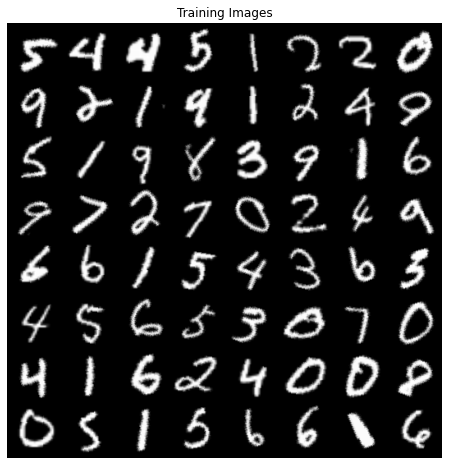

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### The Generator network:
  <img src="https://raw.githubusercontent.com/Mainakdeb/deceptive-digits/main/images/mnist_cgan_generator.png" width="1700">

I concatenated a random noise vector of length 100 with another vector that represents a label of length 10 and passed the resulting tensor through the generator net. Notice that the input tensor has a length of 110. This input vector is passed through transpose-convolution layers to generate a 1x64x64 image.


In [6]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.tconv1 = nn.ConvTranspose2d(nz + 10, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)

        self.tconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)

        self.tconv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)

        self.tconv4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)

        self.tconv6 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)

    def forward(self, x, labels):
        c = self.label_emb(labels)
        c = c.unsqueeze(2).unsqueeze(3)

        # print(c.size())
        # print(x.size())
        x = torch.cat([x, c], 1)
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        # x = F.relu(self.bn5(self.tconv5(x)))
        x = torch.tanh(self.tconv6(x))

        return x


netG = Generator(ngpu).to(device)
print(netG)


Generator(
  (label_emb): Embedding(10, 10)
  (tconv1): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


### The Discriminator network:
  <img src="https://raw.githubusercontent.com/Mainakdeb/deceptive-digits/main/images/mnist_cgan_discriminator.png" width="1700">

A 1x64x64 image is passed through convolution layers and the resulting tensor of length 10 is concatenated with a label embedding of length 10 and the resulting tensor is passed through the linear layers. Notice that the first linear layer takes an input of length 20. The final output is a tensor of length 1, which represents the probability of the sample being real or fake.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        # meta data (label)
        self.label_emb = nn.Embedding(10, 10)

        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)

        self.conv3 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 2)

        self.conv4 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 4)

        self.conv5 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 8)

        self.conv6 = nn.Conv2d(ndf * 8, 10, 4, 1, 0, bias=False)

        self.fc1 = nn.Linear(20, 15)
        self.fc2 = nn.Linear(15, 1)

    def forward(self, x, labels):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        # print(x.size())
        # x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        # print(x.size())
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.leaky_relu(self.conv6(x))
        x = torch.flatten(x, 1)

        c = self.label_emb(labels)
        # print(x.size())
        # print(c.size())
        x = torch.cat([x, c], 1)
        # print(x.size())
        # print(c.size())
        x = F.leaky_relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        # print(x.size())

        return x


netD = Discriminator(ngpu).to(device)
print(netD)


Discriminator(
  (label_emb): Embedding(10, 10)
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=20, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=1, bias=True)
)


### Initiate Weights

In the [DCGAN paper](https://arxiv.org/abs/1511.06434), the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. 

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (label_emb): Embedding(10, 10)
  (tconv1): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

### Load pretrained weights, in case you don't want to train.

In [9]:
# load
netG.load_state_dict(torch.load("/content/deceptive-digits/models/generator_w.pth"))
netD.load_state_dict(torch.load("/content/deceptive-digits/models/discriminator_w.pth"))

<All keys matched successfully>

In [10]:
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

### Training Loop

In [ ]:
num_epochs = 6

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #print((data[1]))
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        real_labels = data[1].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, real_labels).view(-1)
        # Calculate loss on all-real batch
        # print(output[0])
        # print(label[0])
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
        # Generate fake image batch with G
        fake = netG(noise, fake_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), fake_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, fake_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # print training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fake_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/6][0/937]	Loss_D: 1.3971	Loss_G: 0.8272	D(x): 0.4695	D(G(z)): 0.4724 / 0.4382


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/6][50/937]	Loss_D: 0.0842	Loss_G: 4.3825	D(x): 0.9752	D(G(z)): 0.0569 / 0.0129
[0/6][100/937]	Loss_D: 0.2943	Loss_G: 4.7062	D(x): 0.9756	D(G(z)): 0.2324 / 0.0096
[0/6][150/937]	Loss_D: 0.3116	Loss_G: 3.8952	D(x): 0.9245	D(G(z)): 0.1988 / 0.0226
[0/6][200/937]	Loss_D: 0.7395	Loss_G: 3.4416	D(x): 0.8753	D(G(z)): 0.4216 / 0.0349
[0/6][250/937]	Loss_D: 0.2182	Loss_G: 2.9372	D(x): 0.9438	D(G(z)): 0.1449 / 0.0570
[0/6][300/937]	Loss_D: 0.4128	Loss_G: 2.7404	D(x): 0.8790	D(G(z)): 0.2350 / 0.0693
[0/6][350/937]	Loss_D: 2.2313	Loss_G: 3.4149	D(x): 0.1429	D(G(z)): 0.0099 / 0.0363
[0/6][400/937]	Loss_D: 4.1659	Loss_G: 0.0647	D(x): 0.9923	D(G(z)): 0.9831 / 0.9380
[0/6][450/937]	Loss_D: 0.6280	Loss_G: 3.0119	D(x): 0.8818	D(G(z)): 0.3645 / 0.0545
[0/6][500/937]	Loss_D: 0.9133	Loss_G: 1.4494	D(x): 0.6444	D(G(z)): 0.3306 / 0.2701
[0/6][550/937]	Loss_D: 0.8559	Loss_G: 1.5046	D(x): 0.6863	D(G(z)): 0.3354 / 0.2476
[0/6][600/937]	Loss_D: 0.6936	Loss_G: 3.5186	D(x): 0.9078	D(G(z)): 0.4189 / 0.0313
[0/6]

### Visualize training metrics

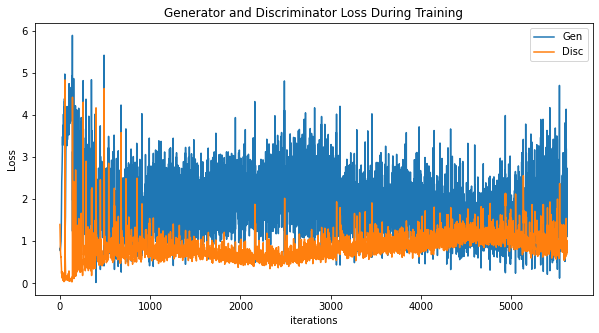

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Gen")
plt.plot(D_losses,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generate one digit:

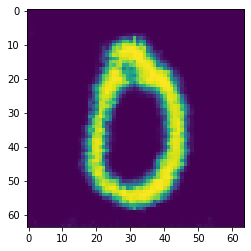

In [11]:
def generate_digit_from_label(label):
  single_noise = torch.randn(1, nz, 1, 1, device=device)
  fake_label = torch.tensor([label]).cuda()
#   print("sn", single_noise.shape)
#   print("label", fake_label.shape)
  with torch.no_grad():
    fake_ = netG(single_noise, fake_label).detach().cpu()
#   print(single_noise.shape, fake_label.shape)
#   print(type(single_noise), type(fake_label))
  return(fake_.squeeze())

plt.imshow(generate_digit_from_label(0))

### Generate images of all classes 

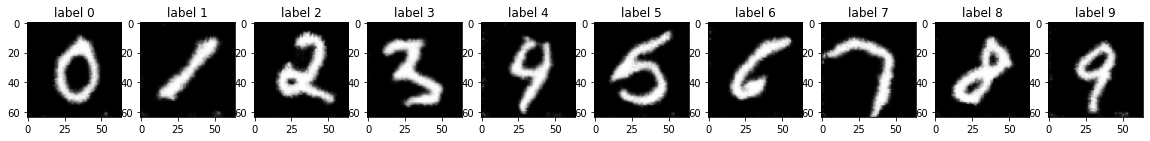

In [ ]:
fig, axes = plt.subplots(1,10, figsize = (20,8))

axes[0].set_title('label 0')
axes[0].imshow(generate_digit_from_label(0), cmap="gray")
axes[1].set_title('label 1')
axes[1].imshow(generate_digit_from_label(1), cmap="gray")
axes[2].set_title('label 2')
axes[2].imshow(generate_digit_from_label(2), cmap="gray")
axes[3].set_title('label 3')
axes[3].imshow(generate_digit_from_label(3), cmap="gray")
axes[4].set_title('label 4')
axes[4].imshow(generate_digit_from_label(4), cmap="gray")
axes[5].set_title('label 5')
axes[5].imshow(generate_digit_from_label(5), cmap="gray")
axes[6].set_title('label 6')
axes[6].imshow(generate_digit_from_label(6), cmap="gray")
axes[7].set_title('label 7')
axes[7].imshow(generate_digit_from_label(7), cmap="gray")
axes[8].set_title('label 8')
axes[8].imshow(generate_digit_from_label(8), cmap="gray")
axes[9].set_title('label 9')
axes[9].imshow(generate_digit_from_label(9), cmap="gray")

### Exploring the Latent Space:
The generator net (here) accepts a latent vector of length 100 and a label embeddding of length 10. While the network trains, it learns to map these latent points to generated images. Every single latent vector is a point in an n-dimensional space where n is the length of the latent vector, which is 100 in this case.

What if you take 2 points in this 100-dimensional space and generate samples by interpolating between them? Every adjacent point leads to the generation of a slightly different image.

The folllowing cell generates images with latent vectors that are interpolated b/w 2 random points.

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)
 
n=20
pts = generate_latent_points(100, n)
interps = []
for i in range(0, n, 2):
    interpolated = interpolate_points(pts[i], pts[i+1], n_steps = 10)    
    z = torch.tensor(interpolated).float().cuda()
    z=z.unsqueeze(2).unsqueeze(3)
    #print(z.shape)
    labels_ = torch.LongTensor(np.ones(10, dtype=int)*i//2).cuda()
    #print(labels_.shape)
    images = netG(z,labels_).detach().cpu().numpy()
    # for x in images:
    #     plt.imshow(x[0])
    #     plt.show()
    interps.append(images)
interps=np.array(interps)

### Visualize images with neighbouring latent points

Notice how each frame is slightly different from the previous. Lets visualize some interpolations side by side, with a different set of interpolated points:

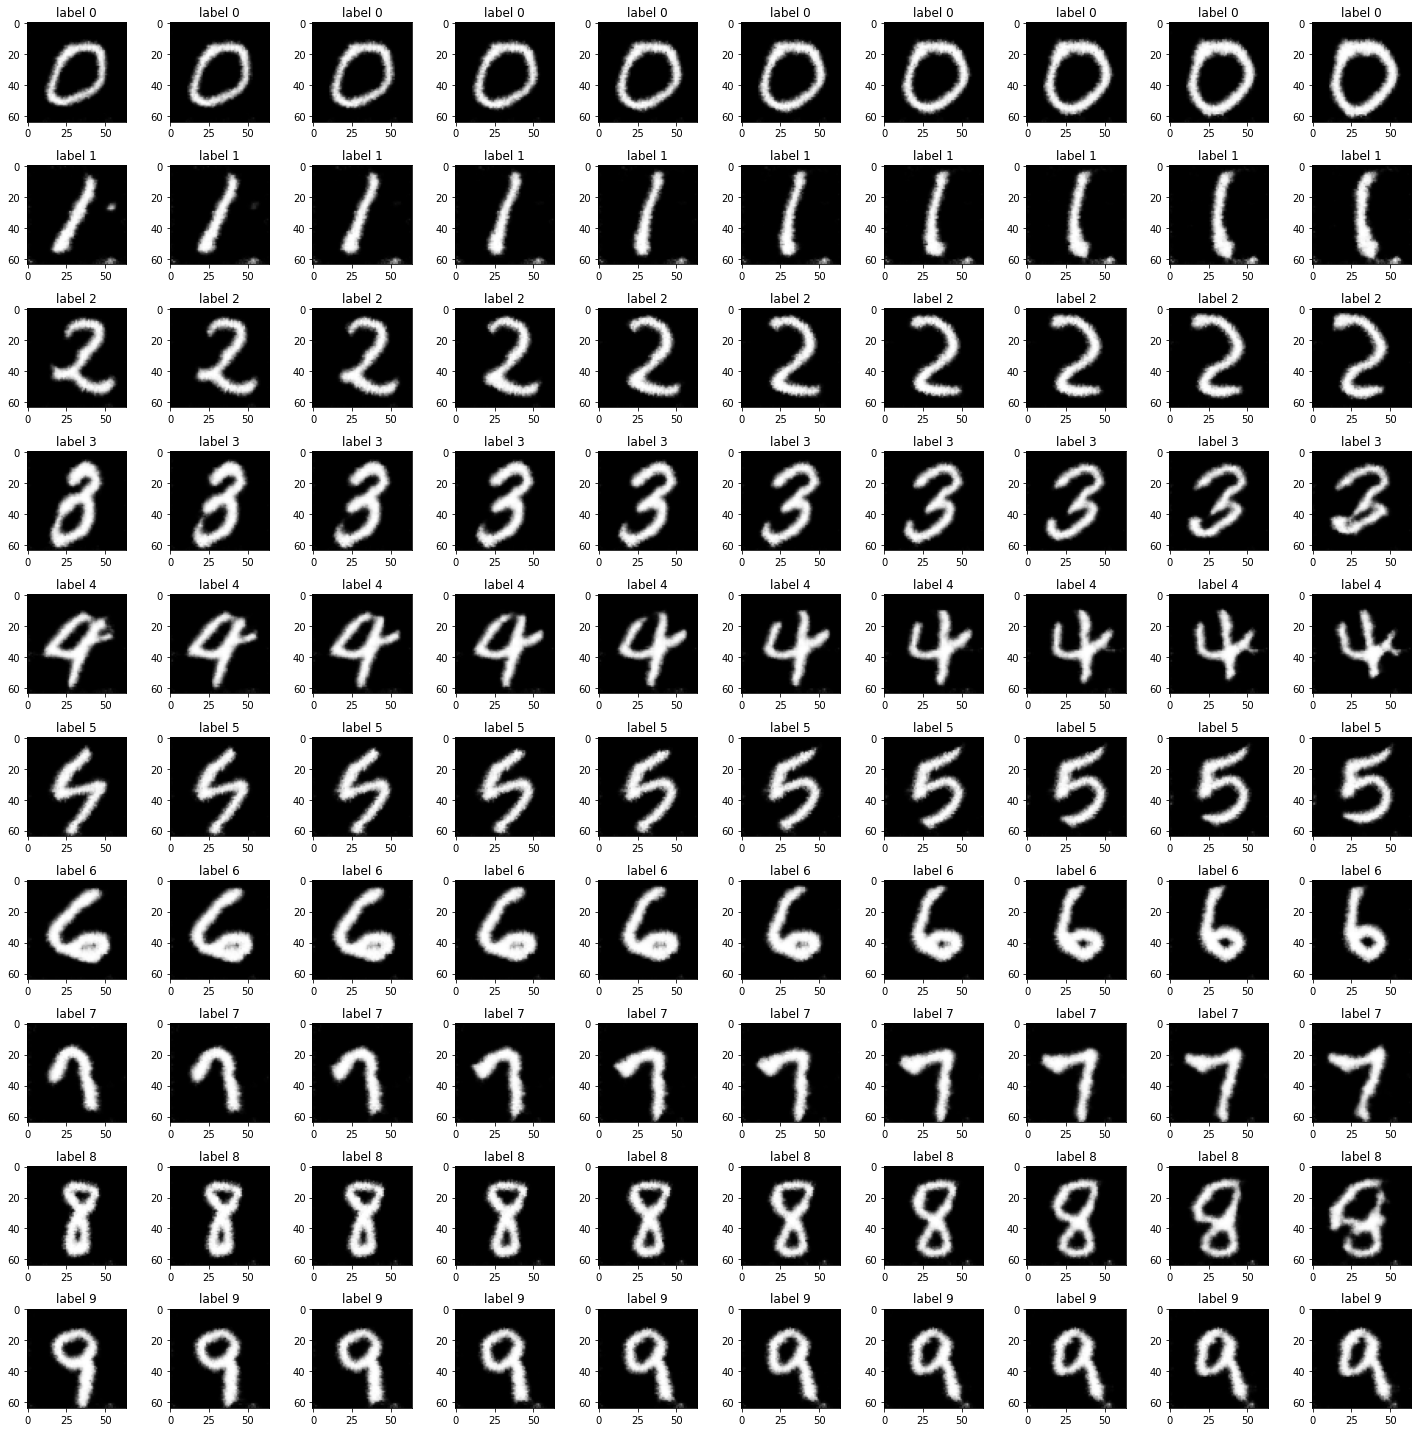

In [ ]:
#Big Plot
fig, axes = plt.subplots(10,10, figsize = (20,20))
for i in range(0, 10):
    for j in range(0,10):
        axes[i,j].set_title('label '+str(i))
        axes[i,j].imshow(interps[i][j][0], cmap='gray')

plt.tight_layout()
plt.show()

 The following gif showcases generated images with latent vectors interpolated between 2 points, looping back and forth between the 2 extremes.

   <img src="https://raw.githubusercontent.com/Mainakdeb/deceptive-digits/main/images/mnist_cgan_interps_loop_10_compressed.gif" width="1700">

 

### Save interpolated images
The following cell was used to save frames, using which the above shown gif was made.

In [ ]:
#save interpolations
fig, axes = plt.subplots(1,10, figsize = (70,10))
for j in range(0,10):
    for i in range(0, 10):
        axes[i].set_title('label '+str(i), FONTSIZE='3')
        axes[i].imshow(interps[i][j][0], cmap="gray")
        fig.savefig("interpolation_"+str(j)+".png") #create gif

for i in range(0,10):
    im = plt.imread("interpolation_"+str(i)+".png")
    plt.imshow(im)
    plt.show()

### How Far Can We Go?
what if you wanted to generate images of numbers with multiple digits? I've used numpy to crop, invert and stich generated images horizontally, check out the generated image below.

In [12]:
def generate_and_save_image_with_multiple_digits(digits):
  gen_list=[]
  for dig in str(digits):
    gen_list.append(generate_digit_from_label(int(dig))[4:60, 10:58])
  vis = np.concatenate((gen_list), axis=1)
  vis = 255-vis
  mimg.imsave("generated"+str(digits)+".png", vis, cmap='gray')
  return(vis)
  

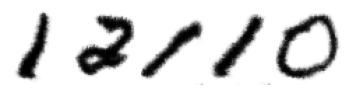

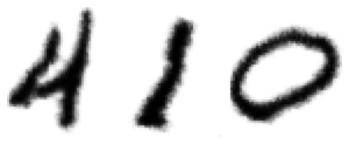

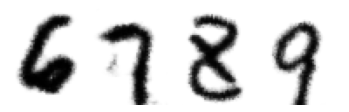

In [ ]:
plt.imshow(generate_and_save_image_with_multiple_digits(12110), cmap='gray')
plt.axis("off")
plt.show()
plt.imshow(generate_and_save_image_with_multiple_digits(410), cmap='gray')
plt.axis("off")
plt.show()
plt.imshow(generate_and_save_image_with_multiple_digits(6789), cmap='gray')
plt.axis("off")
plt.show()

### So, can I make the model _write_ phone numbers for me?
The results speak for themselves.


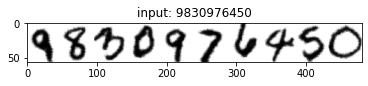

In [44]:
d=9830976450
plt.imshow(generate_and_save_image_with_multiple_digits(d), cmap='gray')
plt.title("input: "+str(d))
plt.show()

### Save model weights:

In [ ]:
torch.save(netG.state_dict(), "generator_w.pth")
torch.save(netD.state_dict(), "discriminator_w.pth")